According to the World Health Organization, cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year. Identifying those at the highest risk of CVDs and ensuring they receive appropriate treatment can prevent premature deaths.

This project aims to identify machine learning classifiers with the highest accuracy to predict individuals that could present heart diseases.

# Data description

1. age: person's age
2. sex: two posible values 
    - 0 = Female 
    - 1 = Male
3. cp: chest pain type
    - 0 = chest pain type
    - 1 = atypical angina
    - 2 = non-anginal pain
    - 3 = asymptomatic
4. trestbps: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl
    - 0 = false
    - 1 = true
7. restecg: resting electrocardiographic results
    - 0 = normal
    - 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina
    - 0 = no
    - 1 = yes
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - 0 = upsloping
    - 1 = flat
    - 2 = downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
    - 0 = error (in the original dataset 0 maps to NaN's)
    - 1 = fixed defect
    - 2 = normal
    - 3 = reversable defect
    
Dataset source: https://www.kaggle.com/ronitf/heart-disease-uci

# Data pre-processing

**Import libraries**

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

**Load csv file**

In [2]:
data = pd.read_csv('heart.csv', decimal = '.')

**Check the first 10 rows**

In [3]:
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


**Dataframe shape**

In [4]:
data.shape

(303, 14)

**Non-categorical variables extraction to make a data summary, this is helpful to find out outliers**

In [5]:
datasum = data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
datasum.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


**Boxplot chart**

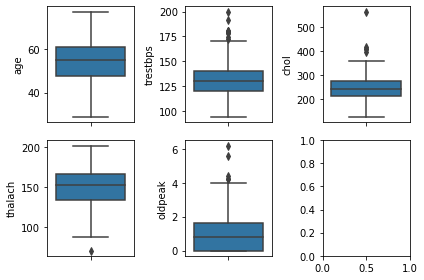

In [6]:
names = list(datasum.columns)
f, axes = plt.subplots(round(len(names)/3), 3)  
y = 0;
for name in names:
    i, j = divmod(y, 3)
    sns.boxplot(y=datasum[name], ax=axes[i, j])
    y = y + 1

plt.tight_layout()
plt.show()

From the Boxplot we can see that all the variables except age own outliers

**Replace outliers with the mean**

In [7]:
for i in names:
    data[str(i)] = np.where((data[str(i)] > np.mean(data[str(i)]) + 3*np.std(data[str(i)])) 
                            | (data[str(i)] < np.mean(data[str(i)]) - 3*np.std(data[str(i)])), 
                            np.mean(data[str(i)]), data[str(i)])

**Check if there are nan values in the columns**

In [8]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

**Change categorical variables**

In [9]:
data['sex'] = np.where(data['sex'] == 1, 'male', 'female')
data['cp'] = np.where(data['cp'] == 0, 'chest pain type', 
                      np.where(data['cp'] == 1, 'atypical angina', 
                               np.where(data['cp'] == 2, 'non-anginal pain', 'asymptomatic')))
data['fbs'] = np.where(data['fbs'] == 1, 'yes', 'no')
data['restecg'] = np.where(data['restecg'] == 0, 'normal', 
                           np.where(data['restecg'] == 1, 'ST-T wave abnormality', 'left ventricular hypertrophy'))
data['exang'] = np.where(data['exang'] == 1, 'yes', 'no')
data['slope'] = np.where(data['slope'] == 0, 'upsloping', 
                           np.where(data['slope'] == 1, 'flat', 'downsloping'))

data['thal'] = np.where(data['thal'] == 1, 'fixed defect', 
                           np.where(data['thal'] == 2, 'normal', 'reversable defect'))

**New variables types**

In [10]:
data.dtypes

age         float64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target        int64
dtype: object

In [11]:
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,male,asymptomatic,145.0,233.0,yes,normal,150.0,no,2.3,upsloping,0,fixed defect,1
1,37.0,male,non-anginal pain,130.0,250.0,no,ST-T wave abnormality,187.0,no,3.5,upsloping,0,normal,1
2,41.0,female,atypical angina,130.0,204.0,no,normal,172.0,no,1.4,downsloping,0,normal,1
3,56.0,male,atypical angina,120.0,236.0,no,ST-T wave abnormality,178.0,no,0.8,downsloping,0,normal,1
4,57.0,female,chest pain type,120.0,354.0,no,ST-T wave abnormality,163.0,yes,0.6,downsloping,0,normal,1
5,57.0,male,chest pain type,140.0,192.0,no,ST-T wave abnormality,148.0,no,0.4,flat,0,fixed defect,1
6,56.0,female,atypical angina,140.0,294.0,no,normal,153.0,no,1.3,flat,0,normal,1
7,44.0,male,atypical angina,120.0,263.0,no,ST-T wave abnormality,173.0,no,0.0,downsloping,0,reversable defect,1
8,52.0,male,non-anginal pain,172.0,199.0,yes,ST-T wave abnormality,162.0,no,0.5,downsloping,0,reversable defect,1
9,57.0,male,non-anginal pain,150.0,168.0,no,ST-T wave abnormality,174.0,no,1.6,downsloping,0,normal,1


We can take a look of the amount of individuals (male and female) that has a heart condition.

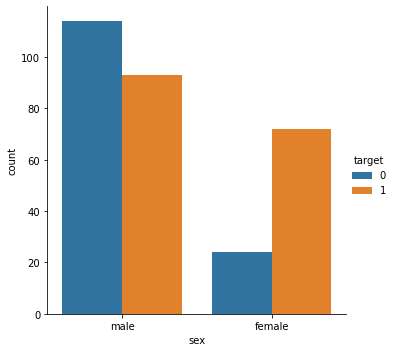

In [12]:
sns.catplot(x = "sex", data=data, hue = 'target', kind='count');

**Dummy variables for categorical columns**

In [13]:
df = pd.get_dummies(data)
df.head(10)

,age,trestbps,chol,thalach,oldpeak,ca,target,sex_female,sex_male,cp_asymptomatic,...,restecg_left ventricular hypertrophy,restecg_normal,exang_no,exang_yes,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,63.0,145.0,233.0,150.0,2.3,0,1,0,1,1,...,0,1,1,0,0,0,1,1,0,0
1,37.0,130.0,250.0,187.0,3.5,0,1,0,1,0,...,0,0,1,0,0,0,1,0,1,0
2,41.0,130.0,204.0,172.0,1.4,0,1,1,0,0,...,0,1,1,0,1,0,0,0,1,0
3,56.0,120.0,236.0,178.0,0.8,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
4,57.0,120.0,354.0,163.0,0.6,0,1,1,0,0,...,0,0,0,1,1,0,0,0,1,0
5,57.0,140.0,192.0,148.0,0.4,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0
6,56.0,140.0,294.0,153.0,1.3,0,1,1,0,0,...,0,1,1,0,0,1,0,0,1,0
7,44.0,120.0,263.0,173.0,0.0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
8,52.0,172.0,199.0,162.0,0.5,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
9,57.0,150.0,168.0,174.0,1.6,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0


**Target Distribution**

In [14]:
def predictive_variable_distribution(data:pd.DataFrame,variable_predict:str, ax = None):
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
    colors = list(dict(**mcolors.CSS4_COLORS))
    df = pd.crosstab(index=data[variable_predict],columns="valor") / data[variable_predict].count()
    countv = 0
    title = "Target Distribution"
    for i in range(df.shape[0]):
        ax.barh(1,df.iloc[i],left = countv, align='center',color=colors[11+i],label= df.iloc[i].name)
        countv = countv + df.iloc[i]
    ax.set_xlim(0,1)
    ax.set_yticklabels("")
    ax.set_ylabel("Target")
    ax.set_title(title)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    countv = 0
    for v in df.iloc[:,0]:
        ax.text(np.mean([countv,countv+v]) - 0.03, 1 , '{:.1%}'.format(v), color='black', fontweight='bold')
        countv = countv + v
    ax.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
    plt.show()

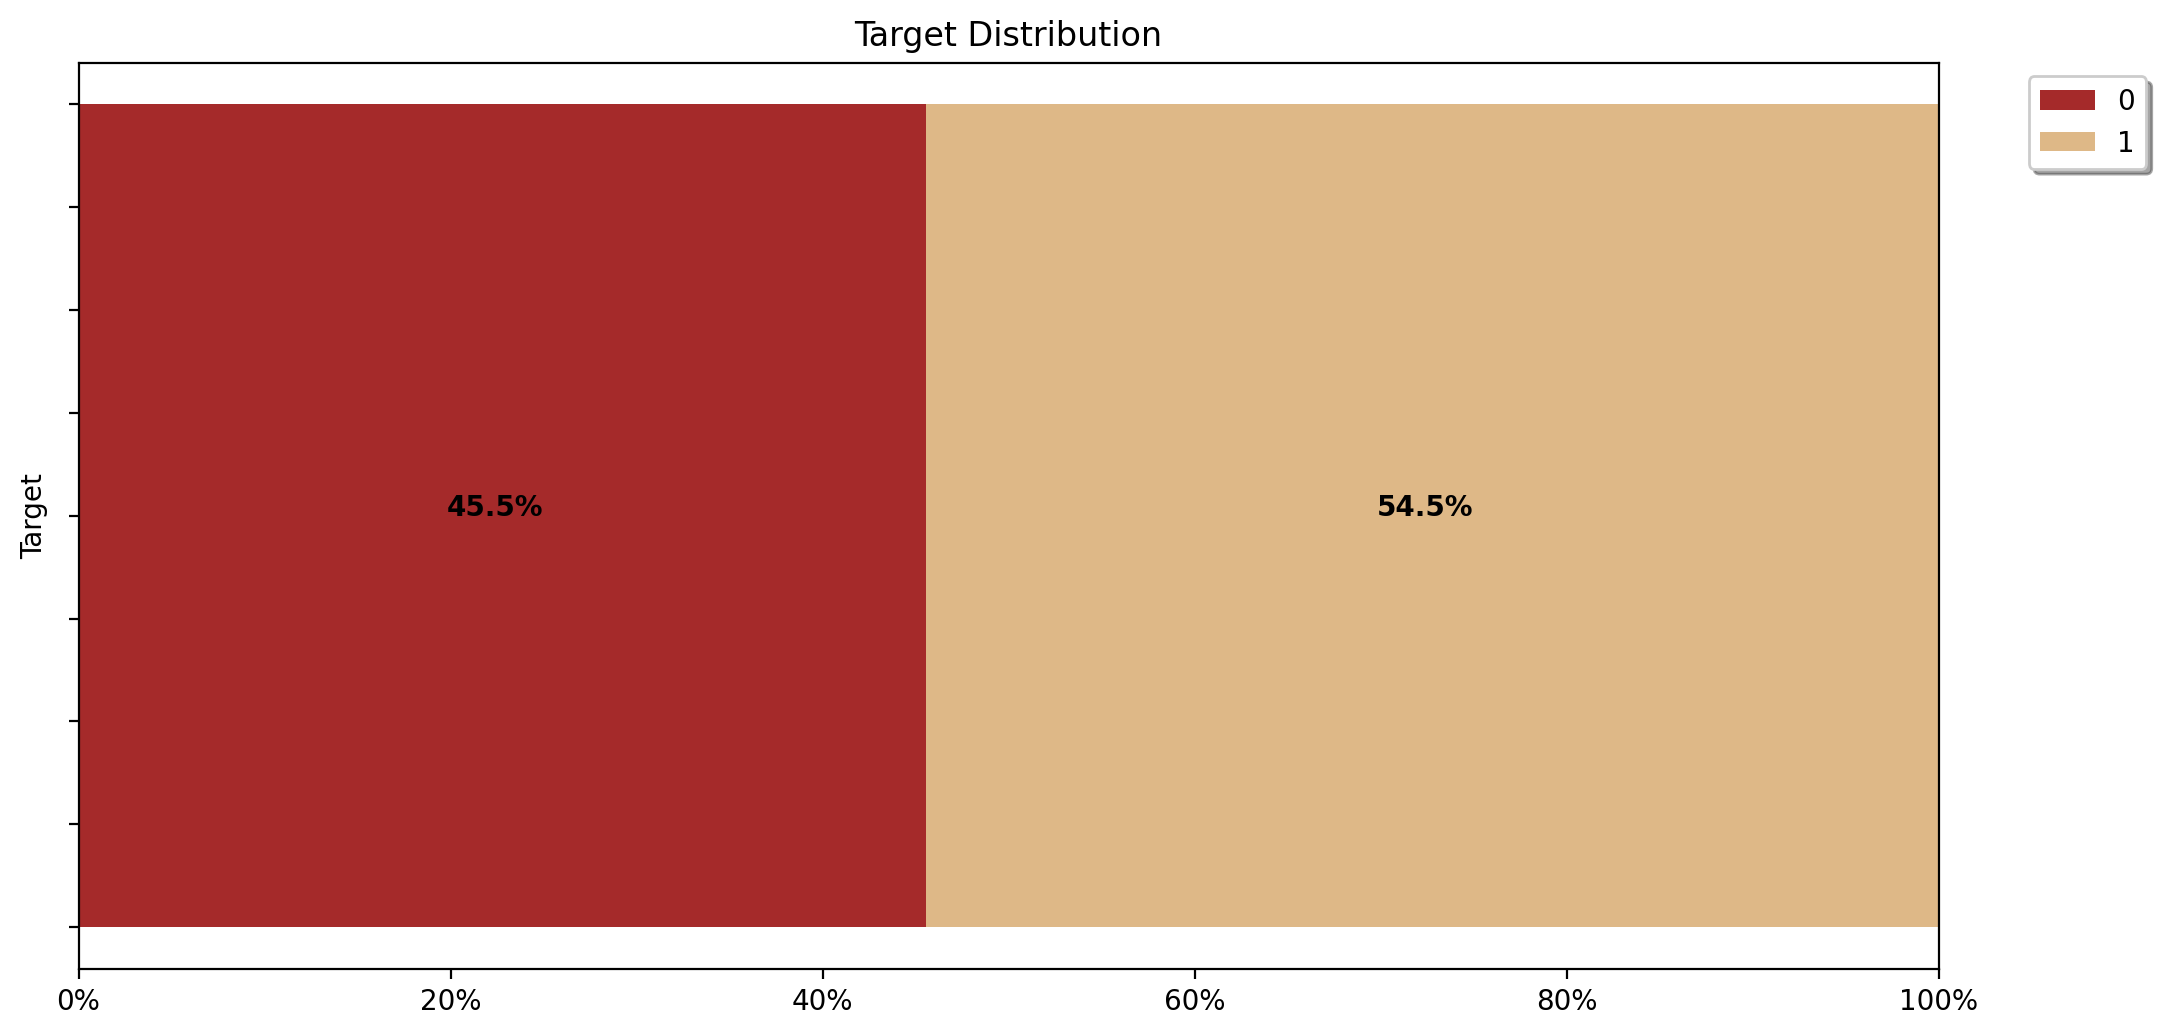

In [15]:
predictive_variable_distribution(df,"target")

# Machine Learning Classifiers

This class will help in the process of building all models that are going to be tested. All models will be set with standard parameters.

In [111]:
class Predictive_Analysis:

    def __init__(self, data: pd.DataFrame, predict: str, predictors=[], model=None, standarize = True,train_size=0.75, 
                 random_state=0):

        self.data = data
        self.predict = predict
        self.predictors = predictors
        self.class_names = list(np.unique(self.data[predict].values))
        self.model = model
        self.random_state = random_state
        if model != None:
            self.train_size = train_size
            self._training_testing(standarize)

    def _training_testing(self, standarize = True):
        if len(self.predictors) == 0:
            X = self.data.drop(columns=[self.predict])
            self.predictors = list(X.columns.values)
        else:
            X = self.data[self.predictors]

        if standarize:
            X = pd.DataFrame(StandardScaler().fit_transform(X), columns= X.columns)

        y = self.data[self.predict].values

        train_test = train_test_split(X, y, train_size=self.train_size,
                                      random_state=self.random_state)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test

    def fit_predict(self):
        if(self.model != None):
            self.model.fit(self.X_train, self.y_train)
            return self.model.predict(self.X_test)

    def fit_predict_results(self):
        if(self.model != None):
            prediccion = self.fit_predict()
            MC = confusion_matrix(self.y_test, prediccion, labels= self.class_names)
            indices = self.indices_general(MC)
            return (MC, indices)

    def indices_general(self, MC, names=None):
        tn = MC[0][0] 
        fp = MC[0][1]
        fn = MC[1][0]
        tp = MC[1][1]
        accuracy = np.sum(MC.diagonal()) / np.sum(MC)
        error = 1 - accuracy
        recall = tp/(tp + fn)
        precision = tp/(tp + fp)
        f1_score = tp/(tp + 1/2*(fp + fn))
        return {"Accuracy": accuracy,
                "Error": error,
                "Recall": recall, 
                "Precision": precision, 
                "F1-Score": f1_score}

In [97]:
def numerical_power_prediction (data:pd.DataFrame, var:str, variable_predict:str):
    sns.FacetGrid(data, hue=variable_predict, height=8, aspect=1.8).map(sns.kdeplot, var, shade=True).add_legend()
    plt.show()
    
def categorical_power_prediction (data: pd.DataFrame, var: str, variable_predict: str, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=200)
    df = pd.crosstab(index=data[var], columns=data[variable_predict])
    df = df.div(df.sum(axis=1), axis=0)
    df.plot(kind='barh', stacked=True, legend=True, ax=ax,
            xlim=(0, 1), width=0.8)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    ax.legend(loc='upper center', bbox_to_anchor=(
        1.08, 1), shadow=True, ncol=1)
    for bars in ax.containers:
        plt.setp(bars, width=.9)
    for i in range(df.shape[0]):
        countv = 0
        for v in df.iloc[i]:
            ax.text(np.mean([countv, countv+v]) - 0.03, i,
                    '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
    plt.show()

###### 1. KNeighbors

In [98]:
kneighbors = KNeighborsClassifier()
target_analysis_kn = Predictive_Analysis(data = df, predict= "target", model = kneighbors,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_kn, metrics_kn = target_analysis_kn.fit_predict_results()

###### 2. Decision Tree

In [99]:
decision_tree = DecisionTreeClassifier()
target_analysis_dt = Predictive_Analysis(data = df, predict= "target", model = decision_tree,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_dt, metrics_dt = target_analysis_dt.fit_predict_results()

###### 3. Random Forest

In [100]:
random_forest = RandomForestClassifier()
target_analysis_rf = Predictive_Analysis(data = df, predict= "target", model = random_forest,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_rf, metrics_rf = target_analysis_rf.fit_predict_results()

###### 4. AdaBoost

In [101]:
ada_boost = AdaBoostClassifier()
target_analysis_ab = Predictive_Analysis(data = df, predict= "target", model = ada_boost,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_ab, metrics_ab = target_analysis_ab.fit_predict_results()

###### 5. XGBoost

In [102]:
xg_boost = GradientBoostingClassifier()
target_analysis_xgb = Predictive_Analysis(data = df, predict= "target", model = xg_boost,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_xgb, metrics_xgb = target_analysis_xgb.fit_predict_results()

###### 6. Support Vector Classifier

In [103]:
svc = SVC()
target_analysis_svc = Predictive_Analysis(data = df, predict= "target", model = svc,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_svc, metrics_svc = target_analysis_svc.fit_predict_results()

###### 7. Naive Bayes

In [104]:
nb = GaussianNB()
target_analysis_nb = Predictive_Analysis(data = df, predict= "target", model = nb,
                                           standarize= True, train_size= 0.75, random_state=0)
confusion_matrix_nb, metrics_nb = target_analysis_nb.fit_predict_results()

### Metrics

In [149]:
summary = pd.DataFrame([metrics_kn, metrics_dt, metrics_rf, metrics_ab, metrics_xgb, metrics_svc, metrics_nb], 
                       index = ('KNeighbors', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 
                                'Support Vector Classifier', 'Naive Bayes'))
summary

,Accuracy,Error,Recall,Precision,F1-Score
KNeighbors,0.855263,0.144737,0.860465,0.880952,0.870588
Decision Tree,0.789474,0.210526,0.813953,0.813953,0.813953
Random Forest,0.815789,0.184211,0.860465,0.822222,0.840909
AdaBoost,0.868421,0.131579,0.883721,0.883721,0.883721
XGBoost,0.815789,0.184211,0.837209,0.837209,0.837209
Support Vector Classifier,0.815789,0.184211,0.883721,0.808511,0.844444
Naive Bayes,0.802632,0.197368,0.860465,0.804348,0.831461


From this table we can see that the highest accuracy is better in AdaBoost.

**Ada Boost Confusion Matrix**

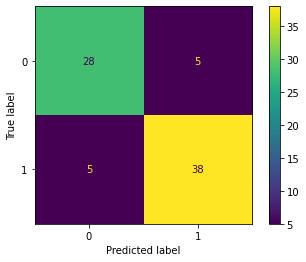

In [138]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ab)
disp.plot()
plt.show()

**Important features for AdaBoost**

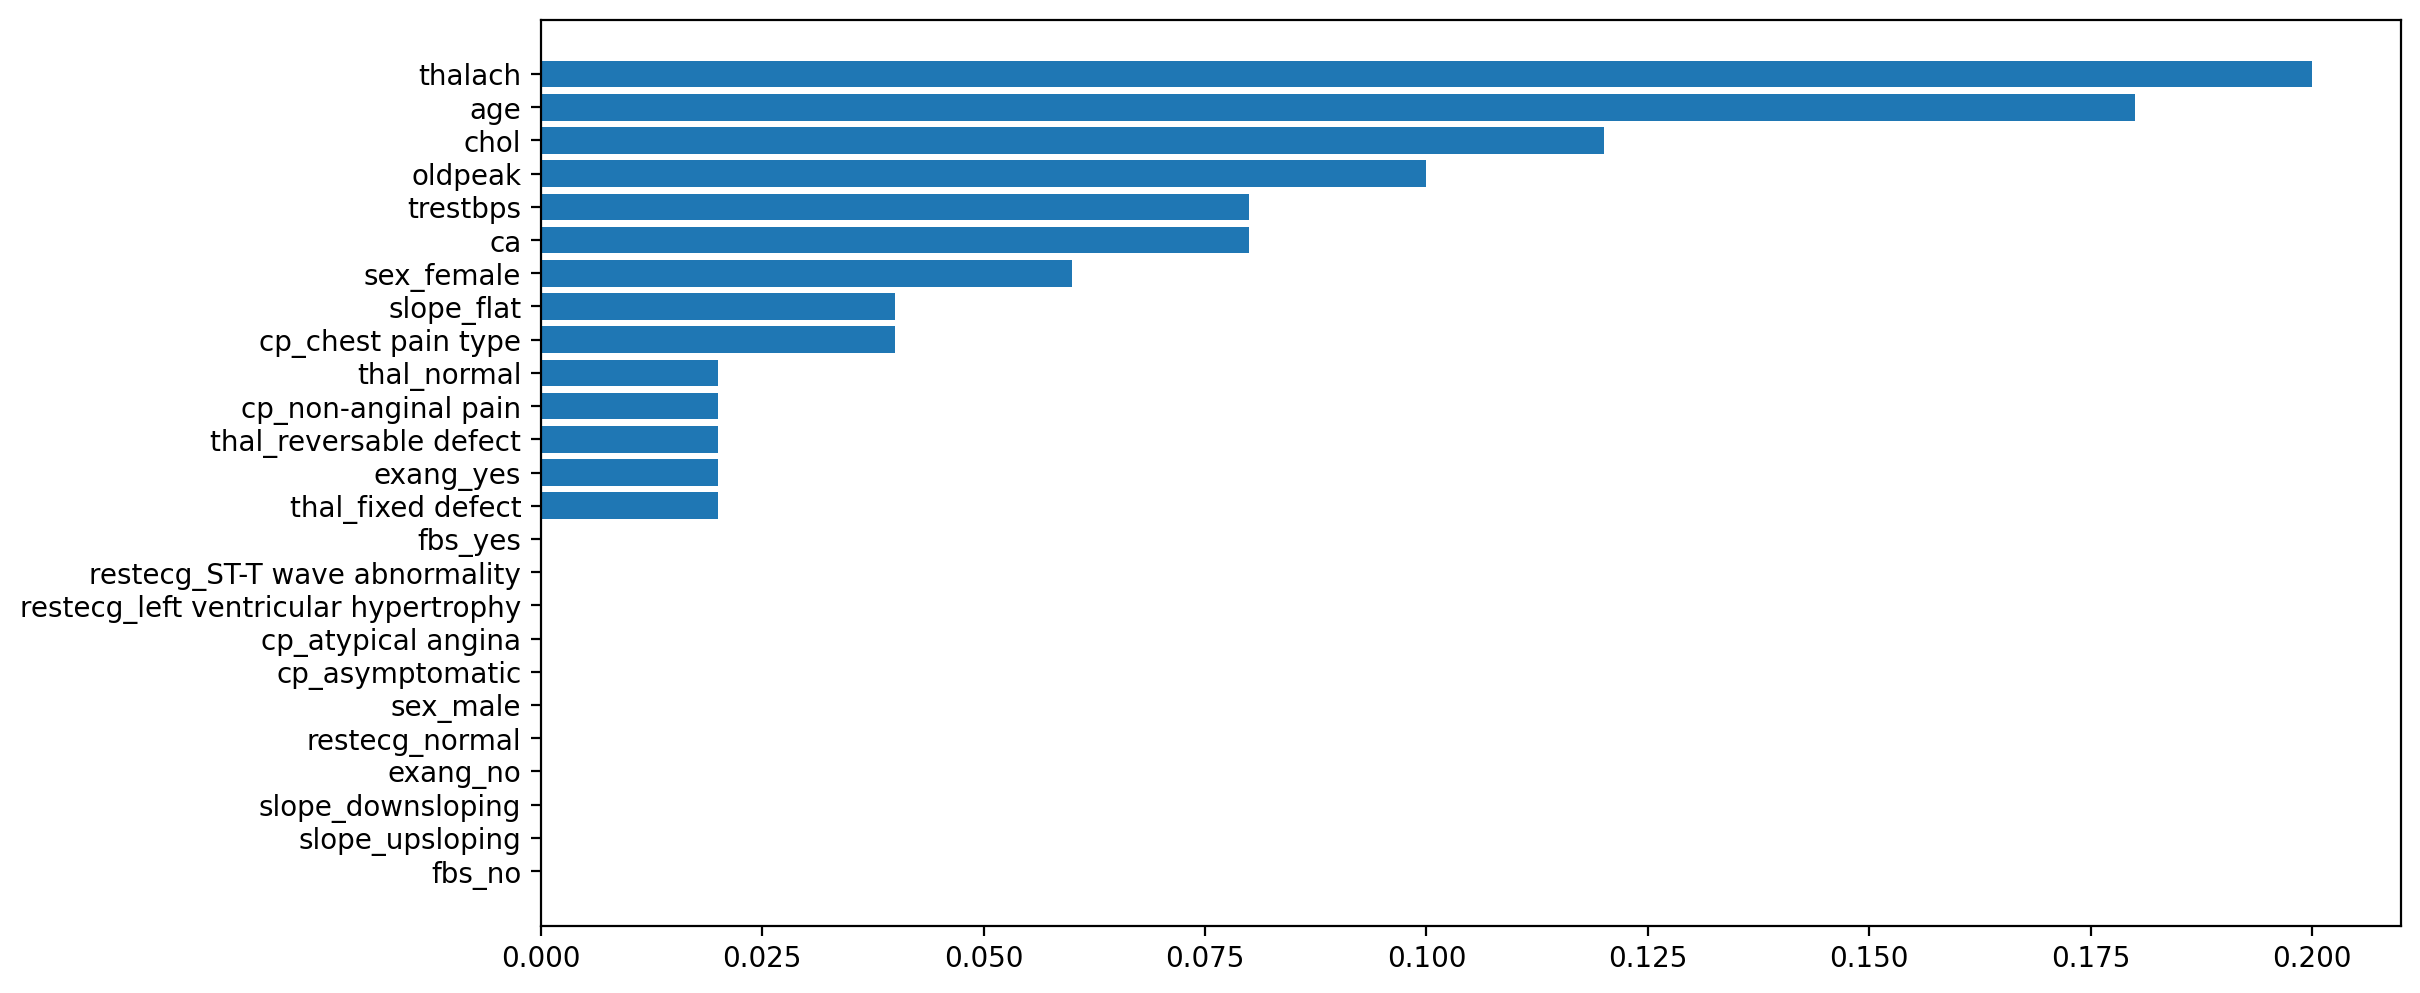

In [148]:
importance = np.array(target_analysis_ab.model.feature_importances_)
label = np.array(target_analysis_ab.predictors)

sort = np.argsort(importance)
importance = importance[sort]
label = label[sort]

fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
ax.barh(label, importance)
plt.show()

# Conclusions

* Using standard parameters, AdaBoost presents the highest accuracy (86.84%) and Decision Tree the lowest (75.00%).
<br>

* Even though AdaBoost has a higher Accuracy, Recall is the same in AdaBoost (AD), and Support Vector Classifier (SVC) which means those models can predict better the individuals who have heart disease. On the other hand, precision is better with AdaBoost.
<br>

* The highest F1-Score belongs to AdaBoost.
<br>

* If we check important features, we can see that some variables are not relevant on detect a heart disease but others are like maximum heart rate achieved, age, serum cholestoral, and others
<br>

* It is fundamental to calibrate all models to find the best parameters. With that, overfit and underfit can be avoided.